# Classification

This case study is based on code from https://github.com/a-martyn/ISL-python

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn import datasets
from IPython.display import display, HTML

%matplotlib inline

In [2]:
def confusion_table(confusion_mtx):
    """Renders a nice confusion table with labels"""
    confusion_df = pd.DataFrame({'y_pred=0': np.append(confusion_mtx[:, 0], confusion_mtx.sum(axis=0)[0]),
                                 'y_pred=1': np.append(confusion_mtx[:, 1], confusion_mtx.sum(axis=0)[1]),
                                 'Total': np.append(confusion_mtx.sum(axis=1), ''),
                                 '': ['y=0', 'y=1', 'Total']}).set_index('')
    return confusion_df


def positive_observations(y):
    # What percentage of observations are positive?
    proportion_1 = ((y == 1).sum() / len(y))
    pct_1        = np.around(proportion_1*100, decimals=3)
    display(HTML('<p><h4>{}%</h4>of observations are positive</p>'.format(pct_1)))


# Classifier stats
# -------------------------------------------------

def prior_error_rate(confusion_matrix):
    """The prior probability that a result is positive"""
    return 1 - (np.sum(confusion_mtx[1, :]) / np.sum(confusion_mtx))

def total_error_rate(confusion_matrix):
    """Derive total error rate from confusion matrix"""
    return 1 - np.trace(confusion_mtx) / np.sum(confusion_mtx)

def true_positive_rate(confusion_mtx):
    """or sensitivity: the proportion of actual POSITIVES that are correctly identified as such"""
    return confusion_mtx[1, 1] / np.sum(confusion_mtx[1, :])

def false_negative_rate(confusion_mtx):
    """the proportion of actual POSITIVES that are incorrectly identified as negative"""
    return confusion_mtx[1, 0] / np.sum(confusion_mtx[1, :])

def false_positive_rate(confusion_mtx):
    """the proportion of actual NEGATIVES that are incorrectly identified as positives"""
    return confusion_mtx[0, 1] / np.sum(confusion_mtx[0, :])

def true_negative_rate(confusion_mtx):
    """or specificity: the proportion of actual NEGATIVES that are correctly identified as such"""
    return confusion_mtx[0, 0] / np.sum(confusion_mtx[0, :])

def positive_predictive_value(confusion_mtx):
    """or precision: the proportion of predicted positives that are correctly predicted"""
    return confusion_mtx[1, 1] / np.sum(confusion_mtx[:, 1])

def negative_predictive_value(confusion_mtx):
    """the proportion of predicted negatives that are correctly predicted"""
    return confusion_mtx[0, 0] / np.sum(confusion_mtx[:, 0])

def classifier_stats(confusion_mtx):
    return pd.Series({'prior_error_rate': prior_error_rate(confusion_mtx),
                      'total_error_rate': total_error_rate(confusion_mtx),
                      'true_positive_rate (sensitivity)': true_positive_rate(confusion_mtx),
                      'false_negative_rate': false_negative_rate(confusion_mtx),
                      'false_positive_rate': false_positive_rate(confusion_mtx),
                      'true_negative_rate (specificity)': true_negative_rate(confusion_mtx),
                      'positive_predictive_value (precision)': positive_predictive_value(confusion_mtx),
                      'negative_predictive_value': negative_predictive_value(confusion_mtx)})


## 11. In this problem, you will develop a model to predict whether a given car gets high or low gas mileage based on the Auto data set.

### (a) Create a binary variable, mpg01, that contains a 1 if mpg contains a value above its median, and a 0 if mpg contains a value below its median. You can compute the median using the median() function. Note you may find it helpful to use the data.frame() function to create a single data set containing both mpg01 and the other Auto variables.

In [3]:
auto_df = pd.read_csv('auto.csv')

# Remove missing values
auto_df = auto_df.drop(auto_df[auto_df.values == '?'].index)
auto_df = auto_df.reset_index()

# Convert quantitive datatypes to numerics
datatypes = {'quant': ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin'],
             'qual': ['name']}

quants = auto_df[datatypes['quant']].astype(np.float_)
auto_df = pd.concat([quants, auto_df[datatypes['qual']]], axis=1) 

# Add mpg01 feature
mpg01   = (auto_df['mpg'] > auto_df['mpg'].median()).astype(np.float64)
auto_df = pd.concat([auto_df, mpg01.rename('mpg01')], axis=1).drop('mpg', axis=1)
auto_df.head()

display(auto_df.head())

,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg01
0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu,0.0
1,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320,0.0
2,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite,0.0
3,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst,0.0
4,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino,0.0


### (b) Explore the data graphically in order to investigate the association between mpg01 and the other features. Which of the other features seem most likely to be useful in predicting mpg01? Scatterplots and boxplots may be useful tools to answer this question. Describe your findings.


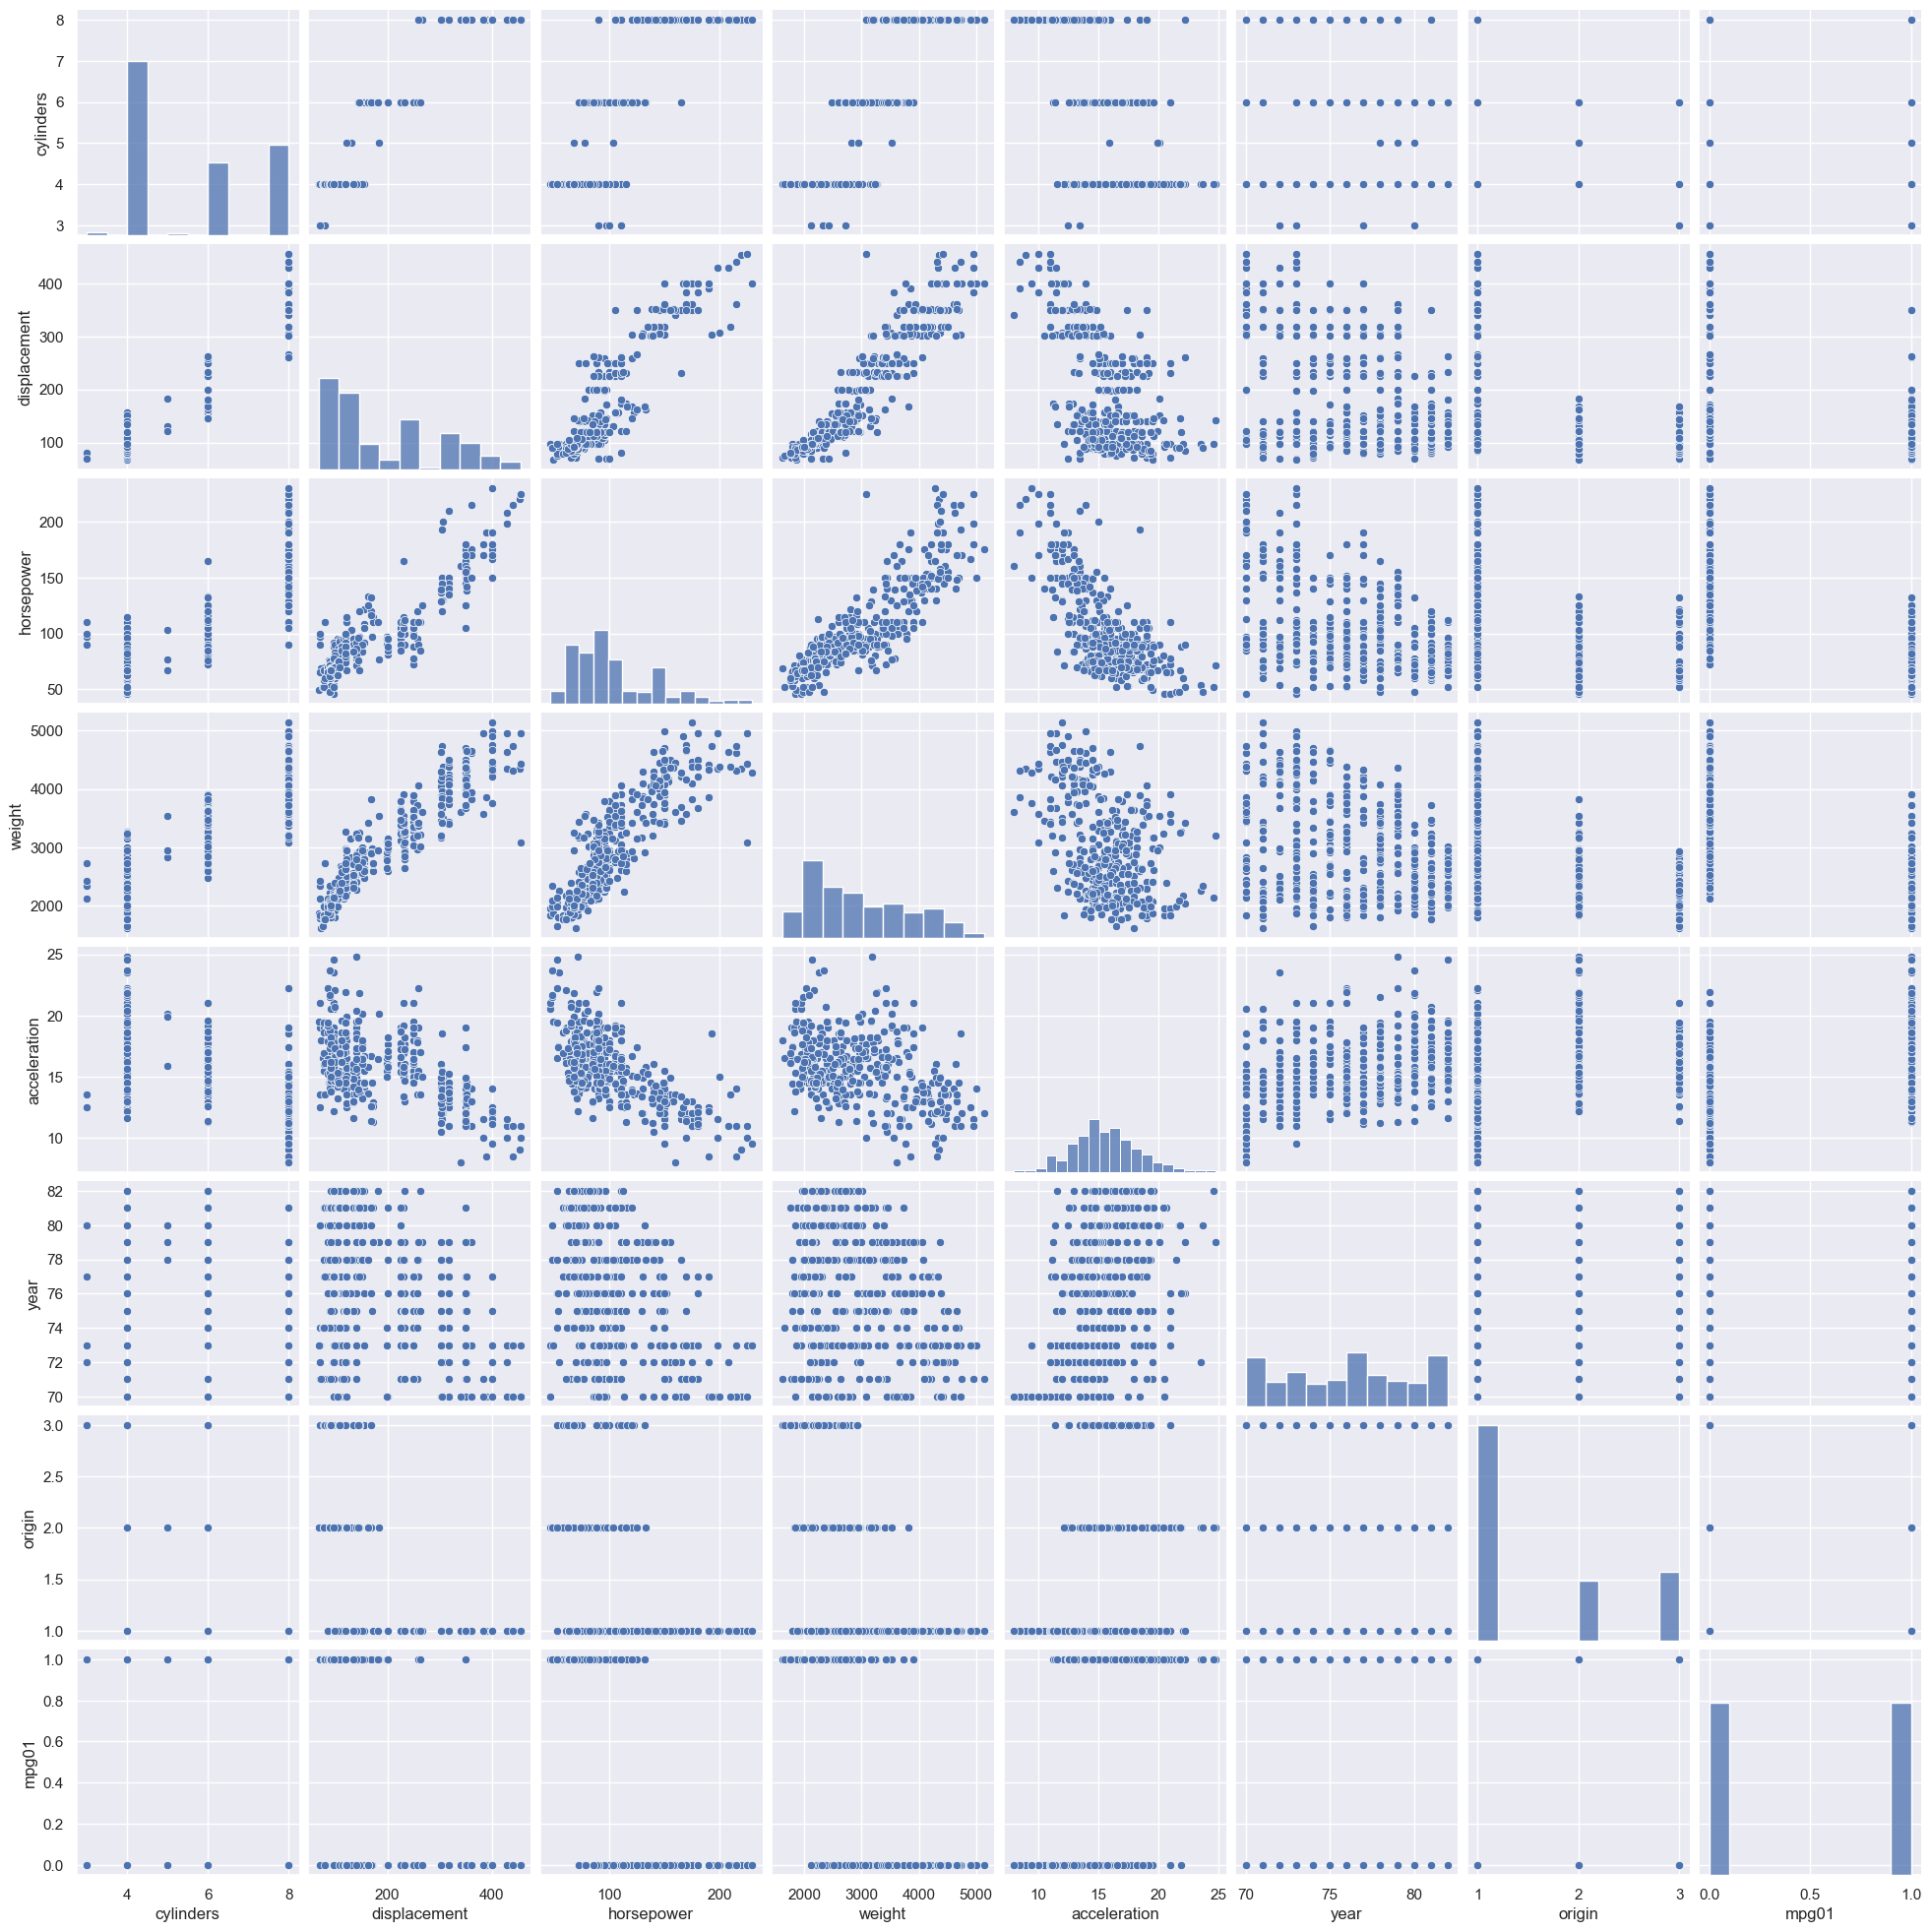

In [4]:
sns.pairplot(auto_df);

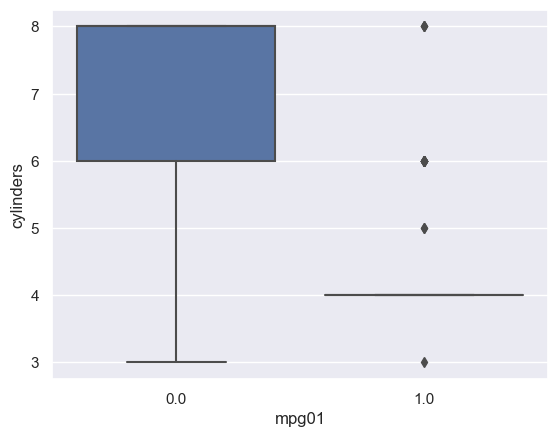

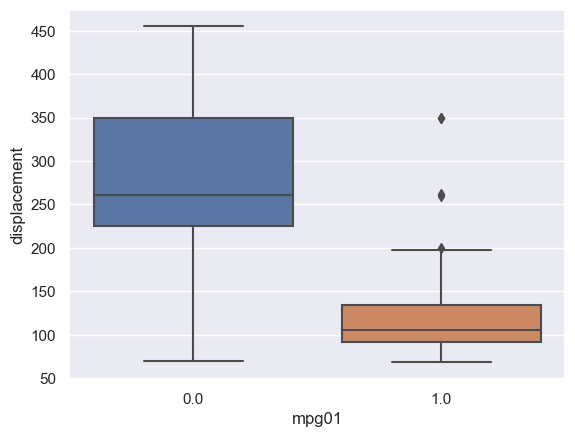

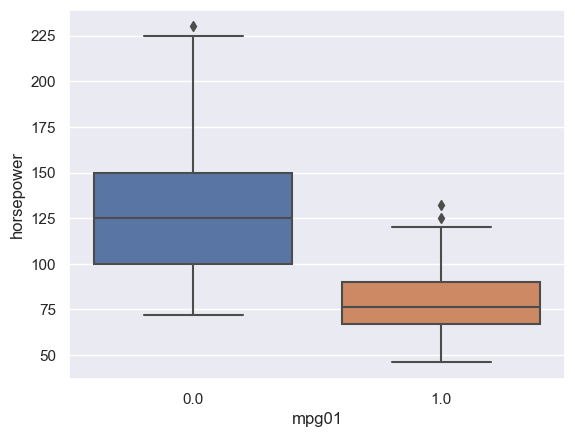

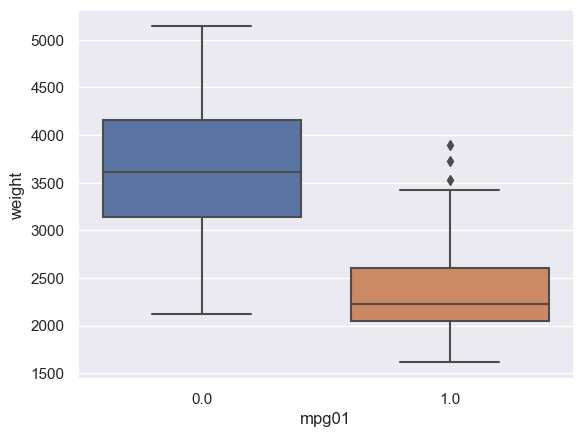

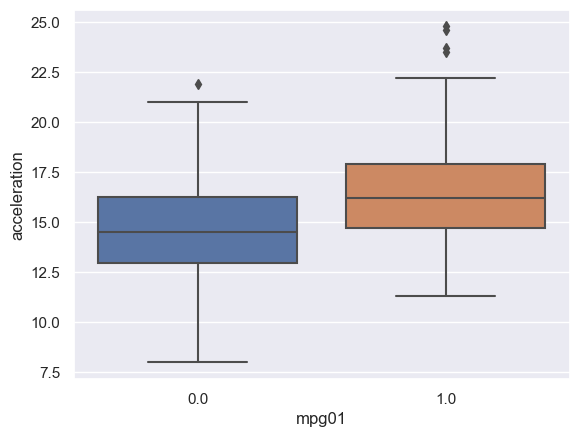

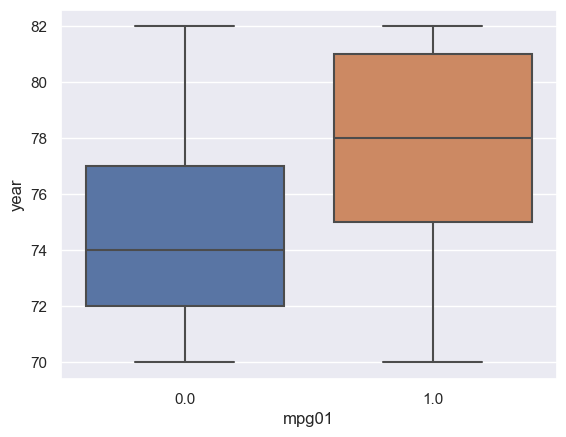

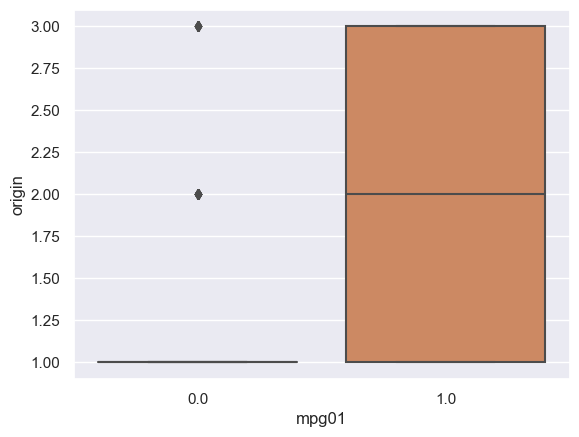

In [5]:
for c in auto_df.columns.drop(['mpg01', 'name']):
    sns.boxplot(x=auto_df['mpg01'], y=auto_df[c])
    plt.show();

Weight, displacement and cyclinders look like the most predictive features.

### (c) Split the data into a training set and a test set.

In [6]:
# Create index for training set
np.random.seed(1)
train = np.random.rand(len(auto_df)) < 0.7

# Training set (70%)
display(HTML('<h3>Training set</h3>'))
display(auto_df[train].head())

# Test set (30%)
display(HTML('<h3>Test set</h3>'))
display(auto_df[~train].head())


,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg01
0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu,0.0
2,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite,0.0
3,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst,0.0
4,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino,0.0
5,8.0,429.0,198.0,4341.0,10.0,70.0,1.0,ford galaxie 500,0.0


,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg01
1,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320,0.0
13,8.0,455.0,225.0,3086.0,10.0,70.0,1.0,buick estate wagon (sw),0.0
20,4.0,110.0,87.0,2672.0,17.5,70.0,2.0,peugeot 504,1.0
21,4.0,107.0,90.0,2430.0,14.5,70.0,2.0,audi 100 ls,1.0
24,6.0,199.0,90.0,2648.0,15.0,70.0,1.0,amc gremlin,0.0


In [7]:


# Create index for training set
np.random.seed(1)
train_idx = np.random.rand(len(auto_df)) < 0.7
auto_df_train = auto_df[train_idx]
auto_df_test  = auto_df[~train_idx]

### (d) Perform LDA on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?

### (e) Perform QDA on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?

### (f) Perform logistic regression on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?

In [8]:
# Create index for holdout set
np.random.seed(1)
train = np.random.rand(len(auto_df)) < 0.7

predictors  = ['weight', 'cylinders', 'year', 'acceleration']
#predictors  = auto_df.columns.drop(['mpg01', 'name'])
X_train = np.array(auto_df[train][predictors])
y_train = np.array(auto_df[train]['mpg01'])
X_test  = np.array(auto_df[~train][predictors])
y_test  = np.array(auto_df[~train]['mpg01'])

# MODELS
# Logistic Regression
#model_logit = sm.Logit(y_train, X_train).fit() <--- this technique didn't converge
logit       = LogisticRegression()
model_logit = logit.fit(X_train, y_train)
# LDA
lda         = LinearDiscriminantAnalysis()
model_lda   = lda.fit(X_train, y_train)
# QDA
qda         = QuadraticDiscriminantAnalysis()
model_qda   = qda.fit(X_train, y_train)


models = {'logit': model_logit, 
          'lda': model_lda, 
          'qda': model_qda}
scaled = []


# PREDICT
for k in models:
    # Predict
    if k in scaled:
        y_pred = models[k].predict(preprocessing.scale(X_test))
    else:
        y_pred = models[k].predict(X_test)
    # Confusion table
    display(HTML('<h3>{}</h3>'.format(k)))
    confusion_mtx = confusion_matrix(y_test, y_pred)
    display(confusion_table(confusion_mtx))
    # Classifier stats
    display(classifier_stats(confusion_mtx))



,y_pred=0,y_pred=1,Total
,,,
y=0,56,10,66
y=1,4,50,54
Total,60,60,


prior_error_rate                         0.550000
total_error_rate                         0.116667
true_positive_rate (sensitivity)         0.925926
false_negative_rate                      0.074074
false_positive_rate                      0.151515
true_negative_rate (specificity)         0.848485
positive_predictive_value (precision)    0.833333
negative_predictive_value                0.933333
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,56,10,66
y=1,2,52,54
Total,58,62,


prior_error_rate                         0.550000
total_error_rate                         0.100000
true_positive_rate (sensitivity)         0.962963
false_negative_rate                      0.037037
false_positive_rate                      0.151515
true_negative_rate (specificity)         0.848485
positive_predictive_value (precision)    0.838710
negative_predictive_value                0.965517
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,2,52,54
Total,59,61,


prior_error_rate                         0.550000
total_error_rate                         0.091667
true_positive_rate (sensitivity)         0.962963
false_negative_rate                      0.037037
false_positive_rate                      0.136364
true_negative_rate (specificity)         0.863636
positive_predictive_value (precision)    0.852459
negative_predictive_value                0.966102
dtype: float64

**Comment**

After some experimentation with features, I achieved the lowest total error rates with with 'weight', 'cylinders', 'year', 'acceleration'.

Without acceleration linear models were superior. Adding acceleration had no effect on linear models but improved qda suggesting that the addition of acceleration adds a non-linear relationship which linear models are unable to represent.

The QDA result can be achieved with LDA by taking log of predictors.

### (g) Perform KNN on the training data, with several values of K, in order to predict mpg01. Use only the variables that seemed most associated with mpg01 in (b). What test errors do you obtain? Which value of K seems to perform the best on this data set?



In [9]:
# Create index for holdout set
np.random.seed(1)
train = np.random.rand(len(auto_df)) < 0.7

predictors  = ['weight', 'cylinders', 'year', 'acceleration']
#predictors  = auto_df.columns.drop(['mpg01', 'name'])
X_train = np.array(auto_df[train][predictors])
y_train = np.array(auto_df[train]['mpg01'])
X_test  = np.array(auto_df[~train][predictors])
y_test  = np.array(auto_df[~train]['mpg01'])



# PREDICT
for K in range(1, 21):
    # model
    model = KNeighborsClassifier(n_neighbors=K).fit(preprocessing.scale(X_train), y_train)
    # Predict
    y_pred = model.predict(preprocessing.scale(X_test))
    
    # Confusion table
    display(HTML('<h3>K={}</h3>'.format(K)))
    confusion_mtx = confusion_matrix(y_test, y_pred)
    display(confusion_table(confusion_mtx))
    
    # Classifier stats
    print('total_error_rate: \n' + str(classifier_stats(confusion_mtx)['total_error_rate']))

,y_pred=0,y_pred=1,Total
,,,
y=0,59,7,66
y=1,2,52,54
Total,61,59,


total_error_rate: 
0.07499999999999996


,y_pred=0,y_pred=1,Total
,,,
y=0,62,4,66
y=1,7,47,54
Total,69,51,


total_error_rate: 
0.09166666666666667


,y_pred=0,y_pred=1,Total
,,,
y=0,59,7,66
y=1,2,52,54
Total,61,59,


total_error_rate: 
0.07499999999999996


,y_pred=0,y_pred=1,Total
,,,
y=0,59,7,66
y=1,3,51,54
Total,62,58,


total_error_rate: 
0.08333333333333337


,y_pred=0,y_pred=1,Total
,,,
y=0,59,7,66
y=1,2,52,54
Total,61,59,


total_error_rate: 
0.07499999999999996


,y_pred=0,y_pred=1,Total
,,,
y=0,59,7,66
y=1,3,51,54
Total,62,58,


total_error_rate: 
0.08333333333333337


,y_pred=0,y_pred=1,Total
,,,
y=0,59,7,66
y=1,2,52,54
Total,61,59,


total_error_rate: 
0.07499999999999996


,y_pred=0,y_pred=1,Total
,,,
y=0,59,7,66
y=1,2,52,54
Total,61,59,


total_error_rate: 
0.07499999999999996


,y_pred=0,y_pred=1,Total
,,,
y=0,58,8,66
y=1,2,52,54
Total,60,60,


total_error_rate: 
0.08333333333333337


,y_pred=0,y_pred=1,Total
,,,
y=0,58,8,66
y=1,2,52,54
Total,60,60,


total_error_rate: 
0.08333333333333337


,y_pred=0,y_pred=1,Total
,,,
y=0,58,8,66
y=1,2,52,54
Total,60,60,


total_error_rate: 
0.08333333333333337


,y_pred=0,y_pred=1,Total
,,,
y=0,58,8,66
y=1,2,52,54
Total,60,60,


total_error_rate: 
0.08333333333333337


,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,2,52,54
Total,59,61,


total_error_rate: 
0.09166666666666667


,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,2,52,54
Total,59,61,


total_error_rate: 
0.09166666666666667


,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,2,52,54
Total,59,61,


total_error_rate: 
0.09166666666666667


,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,2,52,54
Total,59,61,


total_error_rate: 
0.09166666666666667


,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,2,52,54
Total,59,61,


total_error_rate: 
0.09166666666666667


,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,2,52,54
Total,59,61,


total_error_rate: 
0.09166666666666667


,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,2,52,54
Total,59,61,


total_error_rate: 
0.09166666666666667


,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,2,52,54
Total,59,61,


total_error_rate: 
0.09166666666666667


**Comment**

- KNN beats QDA with a total error rate of 7.5% for K = {1, 3, 5, 7, 8} and a slightly lower false positive rate
- the confusion matrix is identical for all top performing K values
- the same predictors appear to work best for KNN as for parametric techniques